In [1]:
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy, torch2np
import os
# from importlib import reload

In [2]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [3]:
# Read the meshgrid for computing the energy

vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)
cut = 13 # removes the influence of inflow/outflow
dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
DX, DY = np.meshgrid(dx,dy)
DX = strip_cross(DX[...,None,None], cut).squeeze()
DY = strip_cross(DY[...,None,None], cut).squeeze()

In [4]:

## Data reading
parameters = [
        (0.01,2.5,0.11111),
        (0.01,3.5,0.11111),
        (0.01,5.0,0.33333),
        (0.01,7.0,0.11111),
        (0.01,7.5,0.33333),
]
# Parameters:
# Re = 1
# Wi = 7.5
# beta = 0.6
Re ,Wi ,beta = parameters[4]
alpha = (1-beta)/(Re*Wi)

# type of simulation
case = 'cross'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)

Nt = X.shape[1] # number of snapshots
q = X.reshape((181,181,5,-1))




X_data = strip_cross(q, cut)
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data)
X = torch2np(X_torch)

#normalize data inside autoencoder
lower_bound = torch.from_numpy(X_data.min(axis = (0,2)).reshape((1,5,1))).float().to(device)
upper_bound = torch.from_numpy(X_data.max(axis = (0,2)).reshape((1,5,1))).float().to(device)


Data shape:  (163805, 999)


In [ ]:
# NN part (Variational AE)
latent_dim = 3
autoencoder = Autoencoder.VariationalAutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)
autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossPred_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))


In [17]:
# NN part (Standard AE)
latent_dim = 3
autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)
autoencoder.load_state_dict(torch.load(f'../Models/Dense_CrossPred_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Run test
with torch.no_grad():
    X_ae_torch,_,_ = autoencoder(X_torch.float()) # Variational
    # X_ae_torch = autoencoder(X_torch.float()) # Standard
X_ae = torch2np(X_ae_torch)

In [7]:
degree = 1
ncomp = latent_dim

# PCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T

# KPCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = DX[None,:], dy = DY[None,:]) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T

In [12]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])
# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

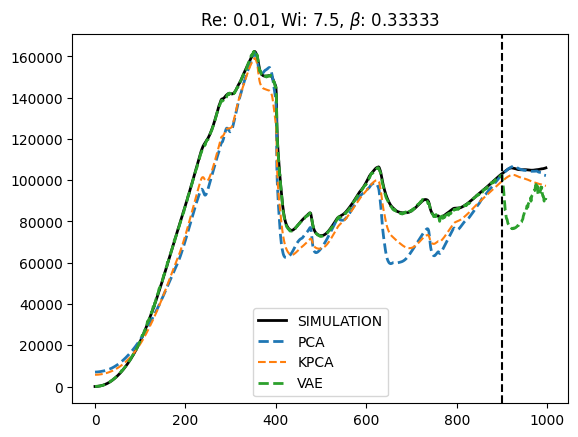

In [13]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')